C:\Users\etyrr\AppData\Local\Temp\ipykernel_9736\4176896231.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r--" (-> color='r'). The keyword argument will take precedence.
  plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line', color='black')


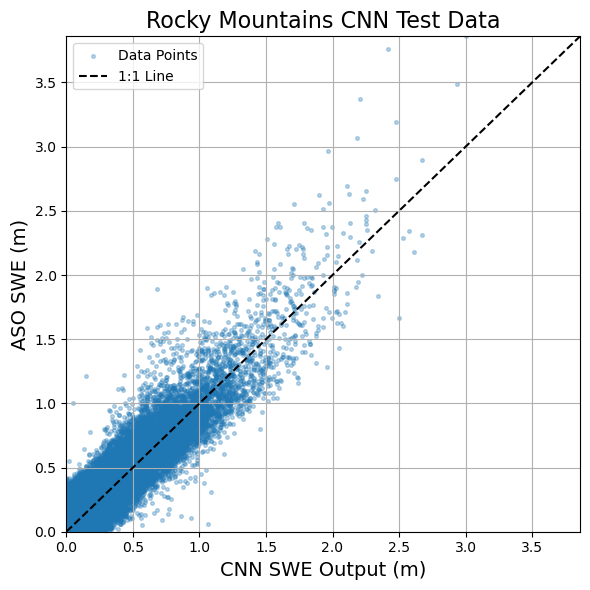

In [19]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# parameters
domain = "Sierras"
modelRun = "20250513_120329"
Group = "G3"

# paths
CNNoutput = r"D:\ASOML\Rockies\modelOutputs\fromAlpine\20250511_230947\outTifs_G2_yPreds_tifs\mosaic_output\blendedOutput_mos_G2_MR20250511_230947_aligned.tif"
ASO = r"D:\ASOML\Rockies\test_groups\ValidationData\ClearCreek_2025099_albn83_60m_SWE.tif"
# Load the two rasters
with rasterio.open(CNNoutput) as src1:
    data1 = src1.read(1)
with rasterio.open(ASO) as src2:
    data2 = src2.read(1)

# Mask invalid data
mask = (~np.isnan(data1)) & (~np.isnan(data2))
x = data1[mask].flatten()
y = data2[mask].flatten()

# Scatterplot
plt.figure(figsize=(6, 6))
plt.scatter(x, y, alpha=0.3, s=7, label='Data Points')

# Add 1:1 line
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='1:1 Line', color='black')

# Final touches
plt.xlabel("CNN SWE Output (m)", fontsize=14)
plt.ylabel("ASO SWE (m)", fontsize=14)
plt.title("Rocky Mountains CNN Test Data", fontsize=16)
plt.legend(fontsize=12)
plt.legend()
plt.grid(True)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.tight_layout()
plt.savefig(fr"Rockies_ClearCreek_scatterplot.png", dpi=600)
plt.show()


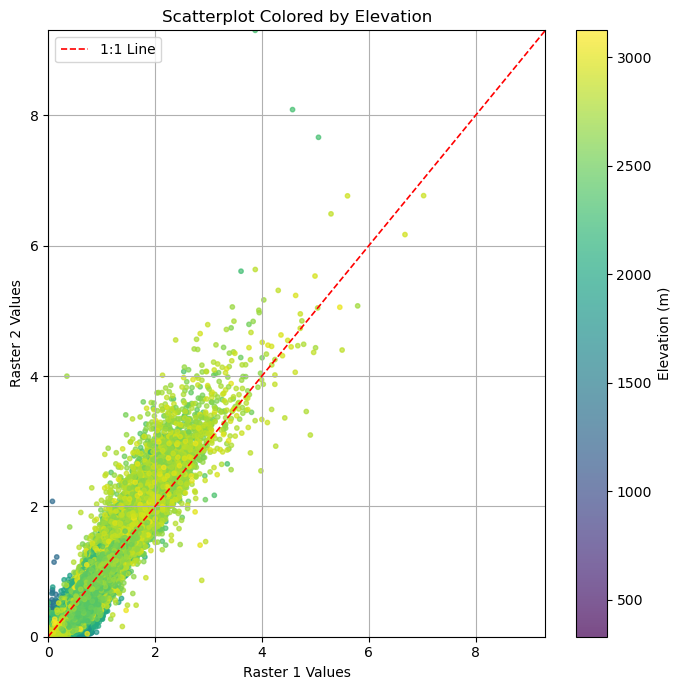

In [17]:
import rasterio
from rasterio.warp import reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt

# File paths
raster1_path = r"D:\ASOML\Sierras\modelOutputs\fromAlpine\20250513_120329\outTifs_G3_yPreds_tifs\mosaic_output\blendedOutput_mos_G3_MR20250513_120329_aligned.tif"
raster2_path = r"D:\ASOML\Sierras\test_groups\ValidationData\American_2025094_albn83_60m_SWE.tif"        # e.g., observed SWE
elevation_path = r"D:\ASOML\Sierras\features\ASOML_SNM_dem_60_albn83.tif"    # elevation raster with larger extent

# --- 1. Read raster1 and raster2 ---
with rasterio.open(raster1_path) as src1:
    data1 = src1.read(1)
    profile1 = src1.profile
    transform1 = src1.transform
    crs1 = src1.crs

with rasterio.open(raster2_path) as src2:
    data2 = src2.read(1)

# --- 2. Read elevation and reproject to raster1’s grid ---
with rasterio.open(elevation_path) as elev_src:
    elevation_raw = elev_src.read(1)
    elev_transform = elev_src.transform
    elev_crs = elev_src.crs

    # Allocate output array same shape as raster1
    elevation_aligned = np.empty_like(data1, dtype=np.float32)

    # Reproject
    reproject(
        source=elevation_raw,
        destination=elevation_aligned,
        src_transform=elev_transform,
        src_crs=elev_crs,
        dst_transform=transform1,
        dst_crs=crs1,
        resampling=Resampling.bilinear
    )

# --- 3. Create mask of valid pixels ---
mask = (
    (~np.isnan(data1)) &
    (~np.isnan(data2)) &
    (~np.isnan(elevation_aligned))
)

x = data1[mask].flatten()
y = data2[mask].flatten()
elev = elevation_aligned[mask].flatten()

# --- 4. Plot scatterplot with elevation as color ---
plt.figure(figsize=(7, 7))
scatter = plt.scatter(x, y, c=elev, cmap='viridis', s=10, alpha=0.7)

# Add 1:1 line
min_val = min(x.min(), y.min())
max_val = max(x.max(), y.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=1.2, label='1:1 Line')

# Final plot adjustments
plt.xlabel("Raster 1 Values")
plt.ylabel("Raster 2 Values")
plt.title("Scatterplot Colored by Elevation")
plt.colorbar(scatter, label='Elevation (m)')
plt.legend()
plt.grid(True)
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.tight_layout()
plt.show()


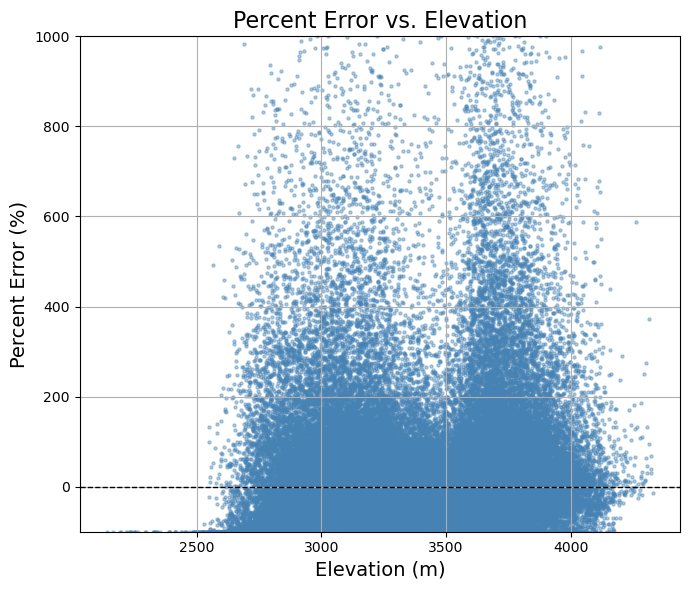

In [23]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt

# File paths
elevation_path = r"D:\ASOML\Rockies\features\ASO_CON_dem_albn83_60m.tif"
error_path = r"D:\ASOML\Rockies\modelOutputs\fromAlpine\20250511_230947\outTifs_G2_yPreds_tifs\mosaic_output\blendedOutput_mos_G2_MR20250511_230947_percentDiff.tif"

# Open rasters
with rasterio.open(elevation_path) as elev_src:
    elev = elev_src.read(1)
with rasterio.open(error_path) as err_src:
    err = err_src.read(1)

# Step 1: Read percent error raster (reference grid)
with rasterio.open(error_path) as err_src:
    err = err_src.read(1)
    err_profile = err_src.profile
    err_transform = err_src.transform
    err_crs = err_src.crs

# Step 2: Read elevation raster
with rasterio.open(elevation_path) as elev_src:
    elev_raw = elev_src.read(1)
    elev_transform = elev_src.transform
    elev_crs = elev_src.crs

# Step 3: Reproject and resample elevation to match error raster
elev_aligned = np.empty_like(err, dtype=np.float32)

reproject(
    source=elev_raw,
    destination=elev_aligned,
    src_transform=elev_transform,
    src_crs=elev_crs,
    dst_transform=err_transform,
    dst_crs=err_crs,
    resampling=Resampling.nearest
)

# Step 4: Create mask for valid data
mask = (~np.isnan(err)) & (~np.isnan(elev_aligned))

elev_vals = elev_aligned[mask].flatten()
err_vals = err[mask].flatten()

# Step 5: Plot
plt.figure(figsize=(7, 6))
plt.scatter(elev_vals, err_vals, alpha=0.4, s=5, color='steelblue')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.ylim(-100, 1000) # zero error line
plt.xlabel("Elevation (m)", fontsize=14)
plt.ylabel("Percent Error (%)", fontsize=14)
plt.title("Percent Error vs. Elevation", fontsize=16)
plt.grid(True)
plt.tight_layout()
# plt.savefig("scatter_error_vs_elevation.png", dpi=600)
plt.show()